In [1]:
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm, inv
import numpy as np

In [82]:
# Take minimum error for all positive and negative x
def min_error(x_hat, x_star):
    errors = []
    for x in x_hat:
            error_positive = np.linalg.norm(x_star - x)
            error_negative = np.linalg.norm(-1*x_star - x)
            errors.append(min(error_positive, error_negative))
    return errors

# Returns the convergence count for errors for a set of test parameters
def convergence_counts(errors, parameter, error_threshold = 1e-8):
    zero_error = {}
    for i in range(len(errors)):
        zero_error[parameter[i]] = 0
        for error in errors[i]:
            zero_error[parameter[i]] += error[-1] < error_threshold
    return zero_error

In [504]:
# Implements BWDG over a stochastic Subspace with thresholding
def bwgd_subspace_threshold(y, A, r, alpha=0, niter = 500):
    d, n = A.shape 
    x = np.zeros((niter, d))  
    x[0] = np.random.randn(d)
    threshold = int(alpha * n)

    # Descent
    for iter in range(1, niter):
        # Find indices for smallest |AtX|
        sorted_indices = np.argsort(np.abs(A.T @ x[iter - 1]))
        indices = sorted_indices[threshold:]

        # Discard the selected indices
        A_filtered = A.T[indices].T.copy()
        y_filtered = y[indices].copy()

        # Covariance matrix transform
        C = A_filtered @ A_filtered.T / n
        C_sqrt = sqrtm(C)
        C_inv = np.real(inv(C_sqrt))
        A_tilde = C_inv @ A_filtered 
        x_tilde = C_sqrt @ x[iter - 1]
        
        # Subspace
        S,_ = np.linalg.qr(np.random.normal(size = (d, r)))
        
        # Hessian
        hessian = (A_tilde @ A_tilde.T) / n
        
        # Gradient
        At_x = A_tilde.T @ x_tilde  
        gradient = hessian @ x_tilde - A_tilde @ (np.sqrt(y_filtered) * At_x / (np.abs(At_x)*n))
        h = np.linalg.solve(S.T @ hessian @ S, -S.T @ gradient)

        x_tilde = x_tilde + S @ h

        x[iter] = C_inv @ x_tilde

        if np.linalg.norm(x[iter] - x[iter-1])<1e-15:
                return x[:iter]
        
    return x

In [530]:
# Implements BWDG over a stochastic Subspace with thresholding
def bwgd_subspace_threshold2(y, A, r, alpha=0, niter = 500):
    d, n = A.shape 
    x = np.zeros((niter, d))  
    x[0] = np.random.randn(d)
    threshold = int(alpha * n)

    # Descent
    for iter in range(1, niter):
        # Find indices for smallest |AtX|
        sorted_indices = np.argsort(np.abs(A.T @ x[iter - 1]))
        indices = sorted_indices[threshold:]

        # Discard the selected indices
        A_filtered = A.T[indices].T.copy()
        y_filtered = y[indices].copy()

        # Covariance matrix transform
        C = A_filtered @ A_filtered.T / n
        C_sqrt = sqrtm(C)
        C_inv = np.real(inv(C_sqrt))
        A_tilde = C_inv @ A_filtered 
        x_tilde = C_sqrt @ x[iter - 1]
        
        # Subspace
        S,_ = np.linalg.qr(np.random.normal(size = (d, r)))
        Q = (np.eye(d) - S @ S.T )    # Projection onto S_perp
        
        # Hessian
        hessian = (A_tilde @ A_tilde.T) / n
        
        # Descent
        At_x = A_tilde.T @ x_tilde  
        gradient = - A_tilde @ (np.sqrt(y_filtered) * (At_x) / np.abs(At_x)) / n
        h = np.linalg.solve(S.T @ hessian @ S, -S.T @ gradient)

        x_tilde = Q @ x_tilde + S @ h

        x[iter] = C_inv @ x_tilde

        if np.linalg.norm(x[iter] - x[iter-1])<1e-15:
                return x[:iter]
        
    return x

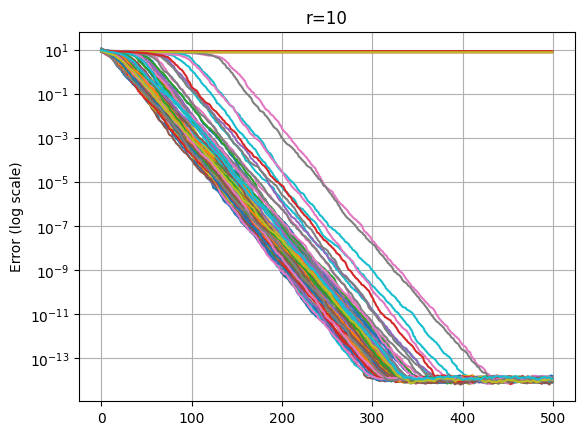

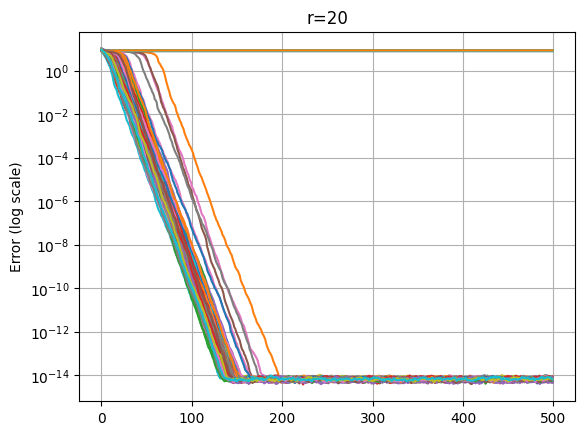

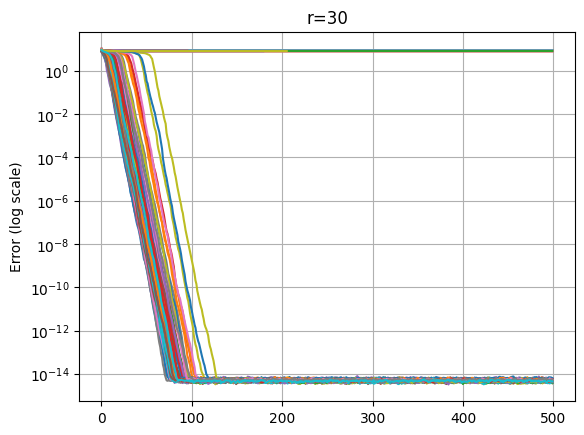

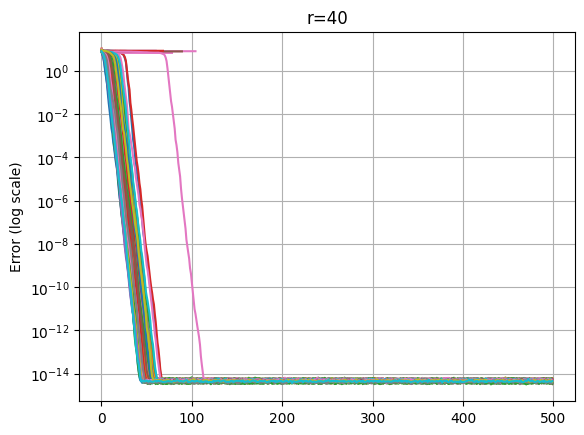

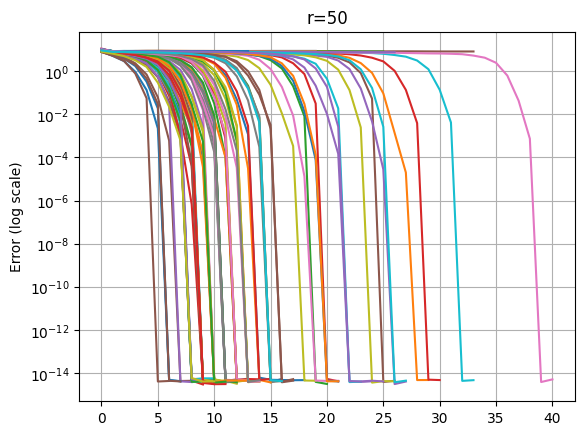

In [382]:
n = 1000
d = 50
errors = []
r_vals =  [10, 20, 30, 40, 50]

for r in r_vals:
    r_error = []
    for j in range(1, 101):  
        # Generate vectors
        x = np.ones(d)
        A = np.random.randn(d, n)
        y = np.square(A.T @ x)
        
        # Run the algorithm
        x_hat = bwgd_subspace_threshold(y, A, r)

        error = min_error(x_hat, x)
        r_error.append(error)
        
        # Plot results
        plt.plot(error)

    errors.append(r_error)

    plt.title(f'r={r}')
    plt.ylabel("Error (log scale)")
    plt.yscale('log')  
    plt.grid(True)
    plt.show()

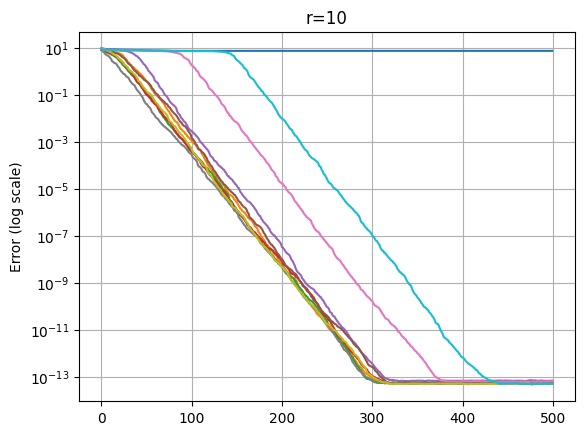

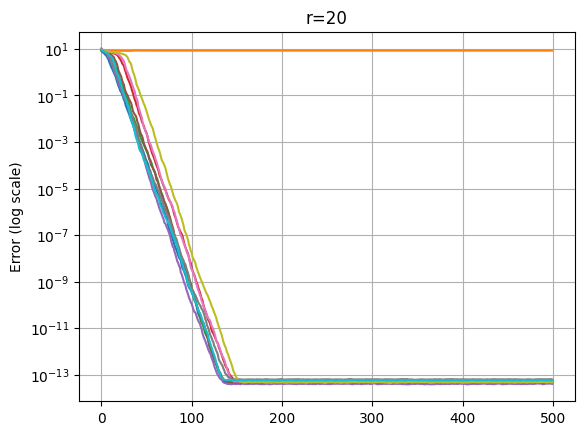

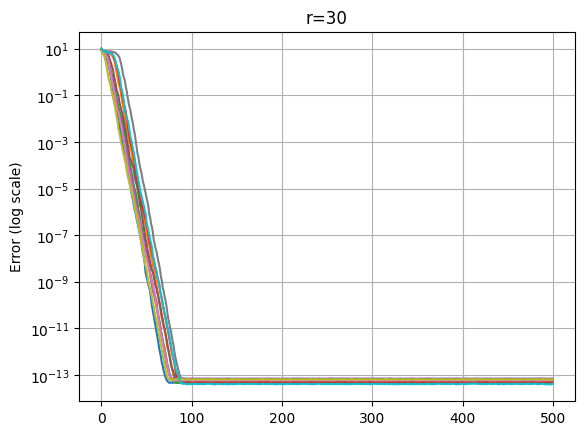

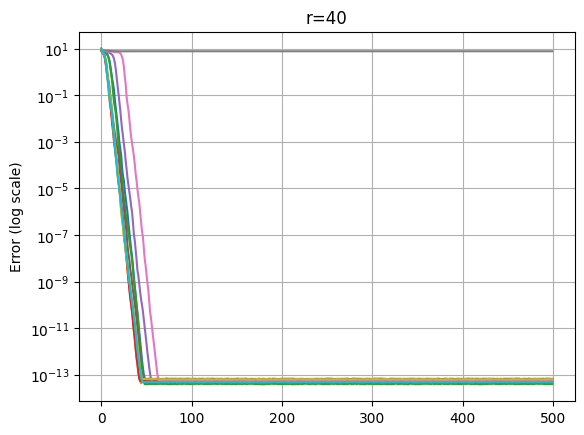

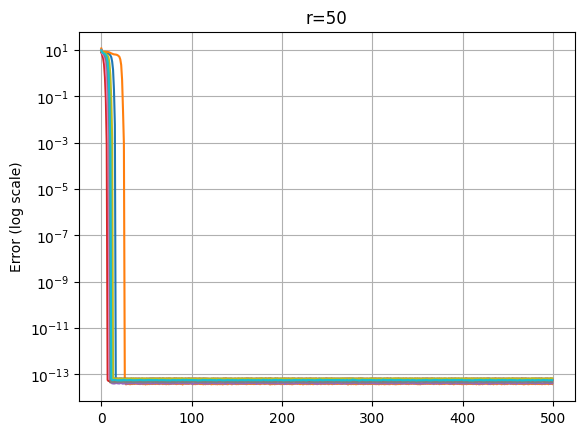

{10: 9, 20: 9, 30: 10, 40: 9, 50: 10}

In [529]:
n = 1000
d = 50
errors = []
r_vals =  [10, 20, 30, 40, 50]

for r in r_vals:
    r_error = []
    for j in range(1, 11):  
        # Generate vectors
        x = np.ones(d)
        A = np.random.randn(d, n)
        y = np.square(A.T @ x)
        
        # Run the algorithm
        x_hat = bwgd_subspace_threshold2(y, A, r)

        error = min_error(x_hat, x)
        r_error.append(error)
        
        # Plot results
        plt.plot(error)

    errors.append(r_error)

    plt.title(f'r={r}')
    plt.ylabel("Error (log scale)")
    plt.yscale('log')  
    plt.grid(True)
    plt.show()
convergence_counts(errors, r_vals)

Thresholding

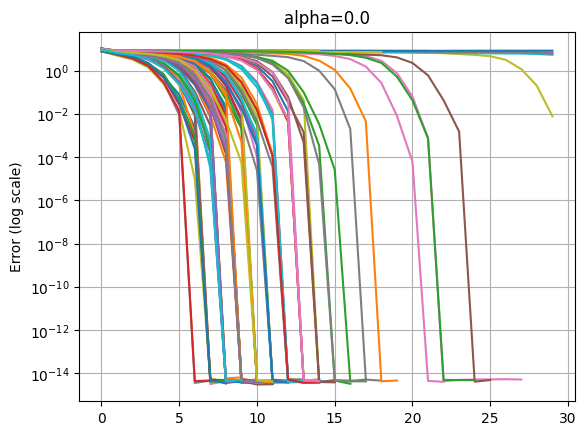

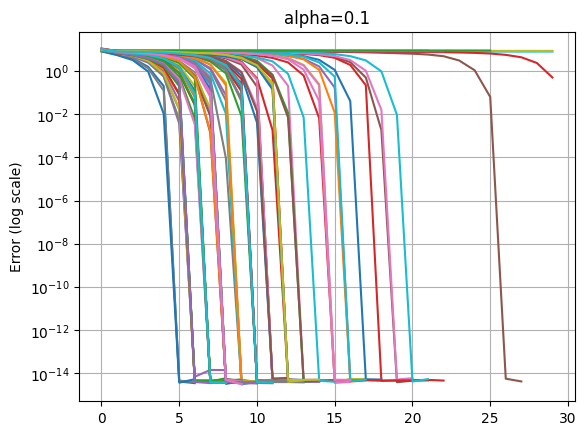

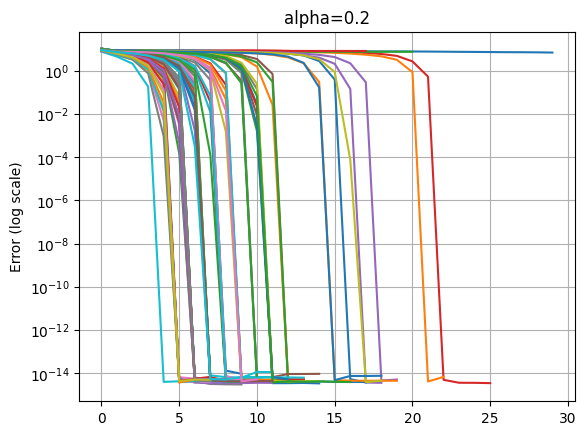

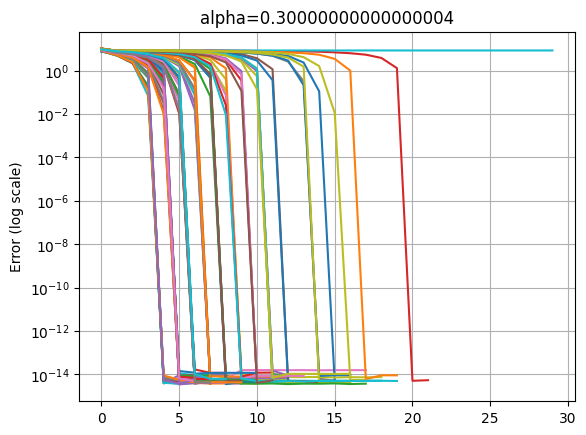

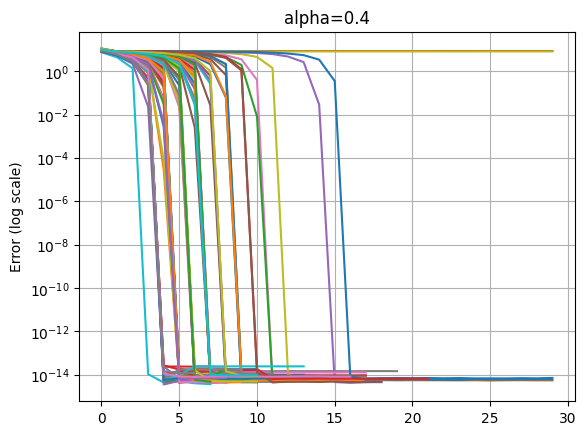

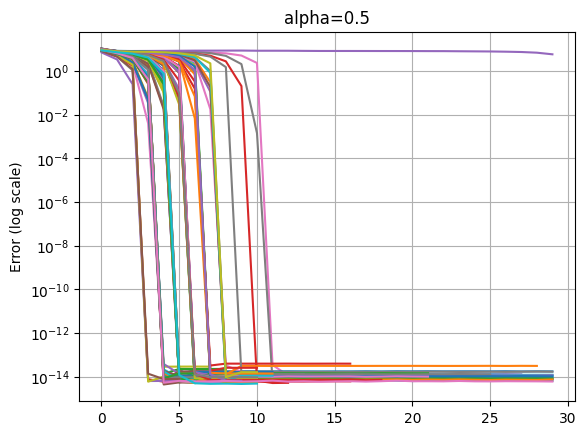

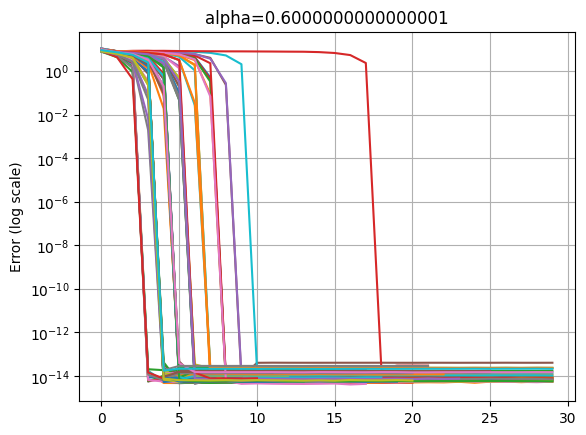

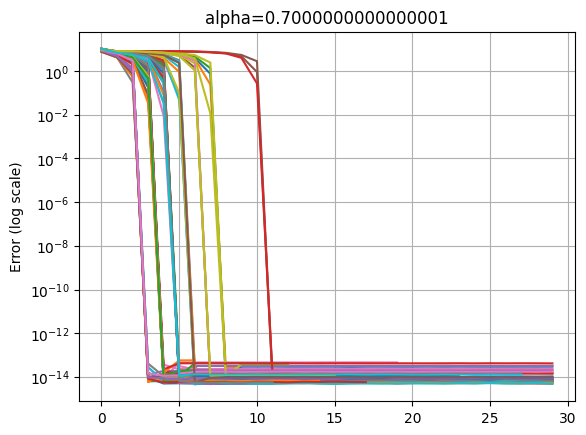

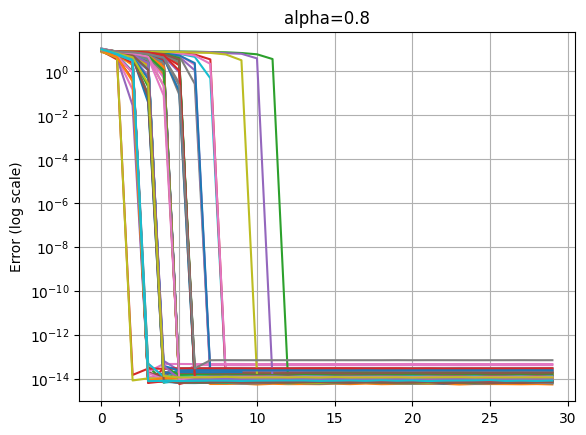

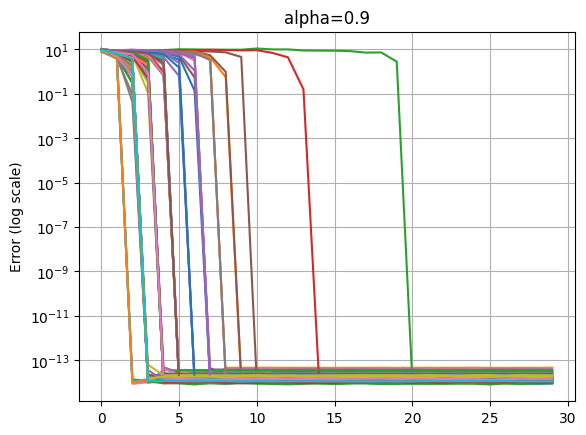

{0.0: 89,
 0.1: 94,
 0.2: 97,
 0.30000000000000004: 99,
 0.4: 98,
 0.5: 99,
 0.6000000000000001: 100,
 0.7000000000000001: 100,
 0.8: 100,
 0.9: 100}

In [411]:
n = 1000
d = 50
alphas = np.arange(0, 10)*0.1
errors = []

for alpha in alphas:
    alpha_error = []
    for j in range(1, 101):  
        # Generate vectors
        x = np.ones(d)
        A = np.random.randn(d, n)
        y = np.square(A.T @ x)
        
        # Run the algorithm
        x_hat = bwgd_subspace_threshold(y, A, r=d, alpha=alpha, niter=30)
        error = min_error(x_hat, x)
        alpha_error.append(error)
        
        # Plot results
        plt.plot(error)

    errors.append(alpha_error)
    plt.title(f'alpha={alpha}')
    plt.ylabel("Error (log scale)")
    plt.yscale('log')  
    plt.grid(True)
    plt.show()
convergence_counts(errors, alphas)

Trajectory Projection

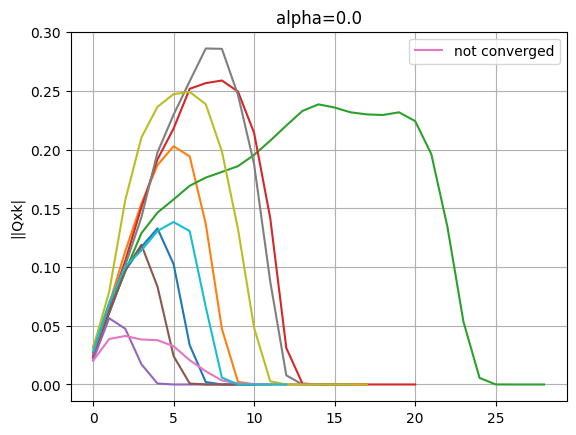

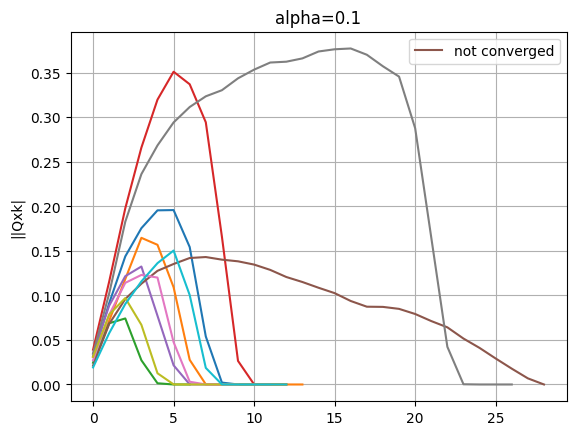

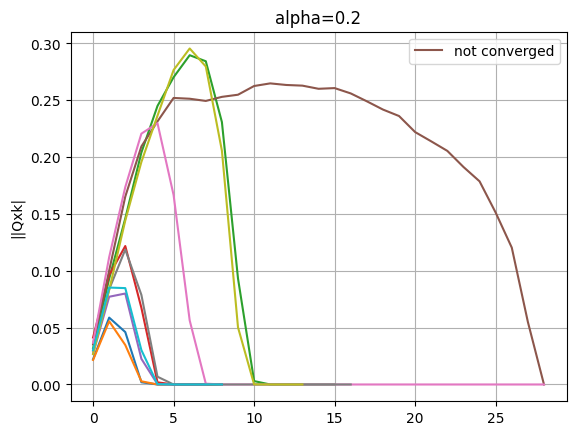

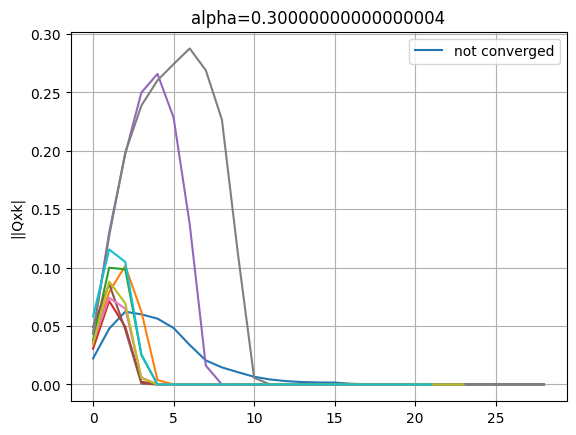

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


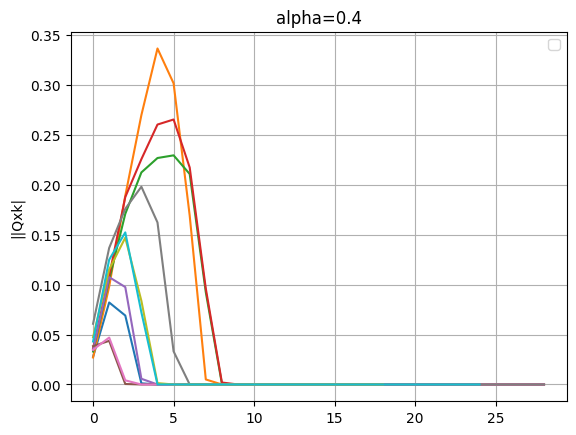

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


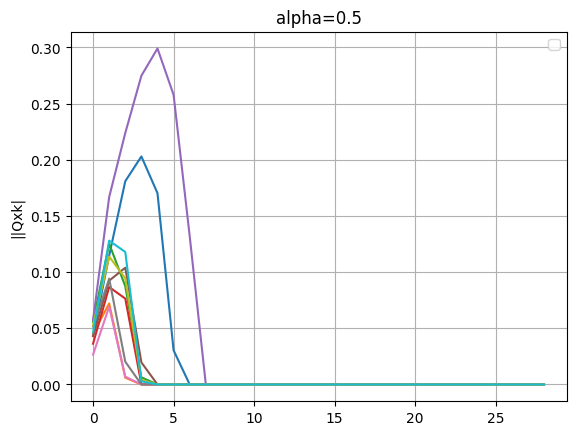

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


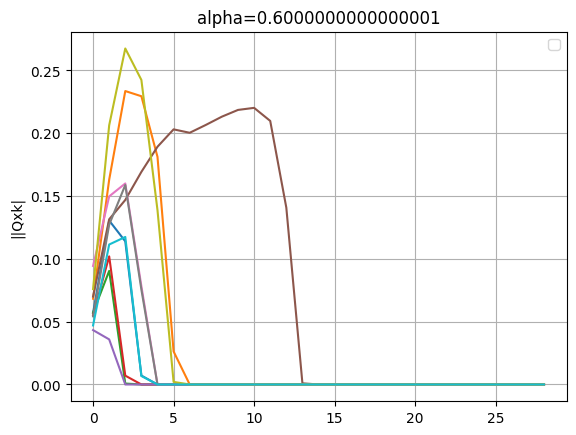

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


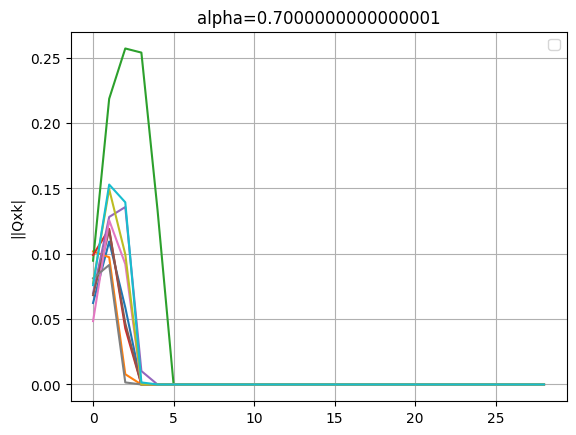


KeyboardInterrupt



Error in callback <function flush_figures at 0x00000232E1D6AE80> (for post_execute):



KeyboardInterrupt



In [505]:
n = 1000
d = 50
alphas = np.arange(0, 10)*0.1
errors = []

for alpha in alphas:
    alpha_error = []
    for j in range(1, 11):  
        # Generate vectors
        x = np.ones(d)
        A = np.random.randn(d, n)
        y = np.square(A.T @ x)
        
        # Run the algorithm
        x_hat = bwgd_subspace_threshold(y, A, r=d, alpha=alpha, niter=30)

        # Check for convergence

        # Projection
        x0 = x_hat[0]
        x_star = x_hat[-1]
        U = np.column_stack([x0, x_star])
        Q, _ = np.linalg.qr(U)  
        QL = np.eye(d) - Q @ Q.T 

        # Compute norm for x_k in x_hat
        norm_QL_xk = [(np.linalg.norm(QL @ x_k)**2)/d for x_k in x_hat[1:]]
        alpha_error.append(norm_QL_xk)

        # Plot results
        if min_error(x_hat, np.ones(d))[-1]>1e-8:
            plt.plot(norm_QL_xk, label="not converged")
        else:
            plt.plot(norm_QL_xk)

    errors.append(alpha_error)
    plt.title(f'alpha={alpha}')
    plt.legend()
    plt.ylabel("||Qxk|")
    plt.grid(True)
    plt.show()

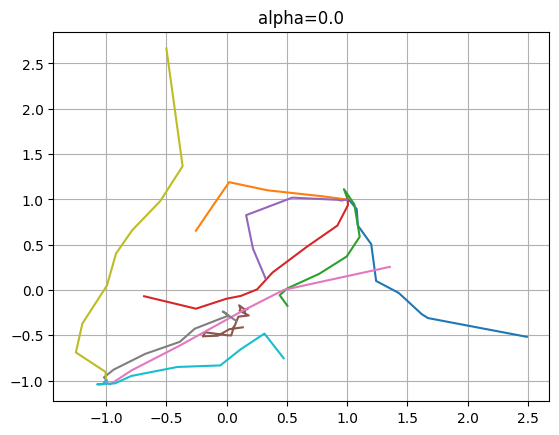

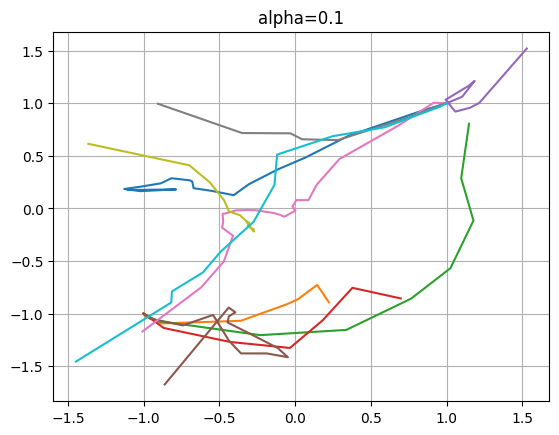

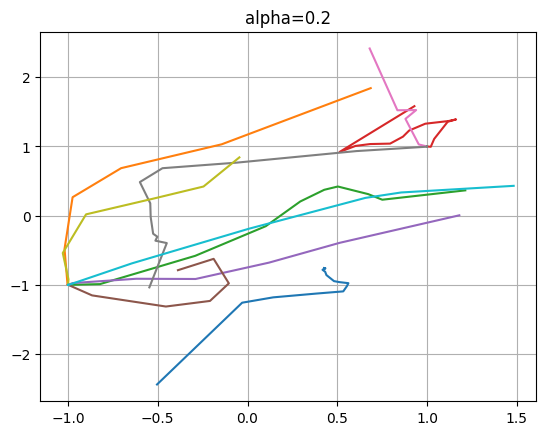

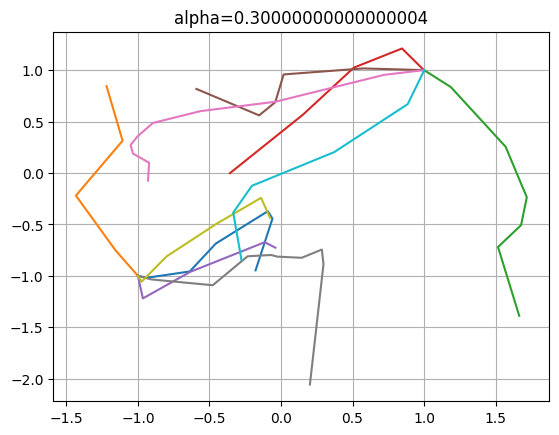

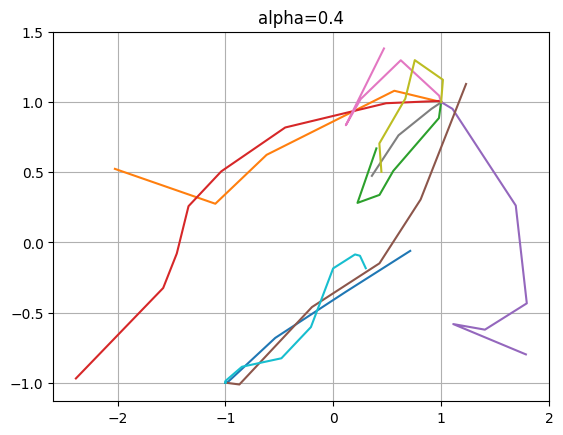

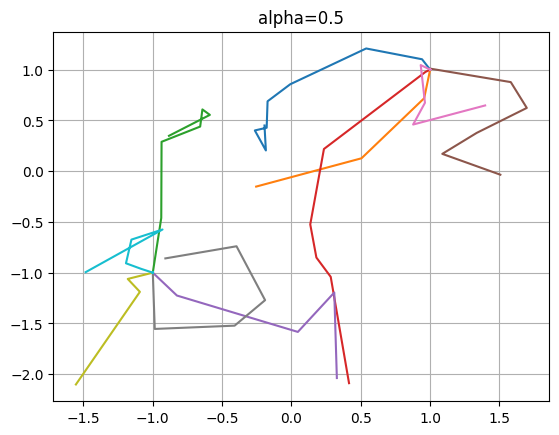

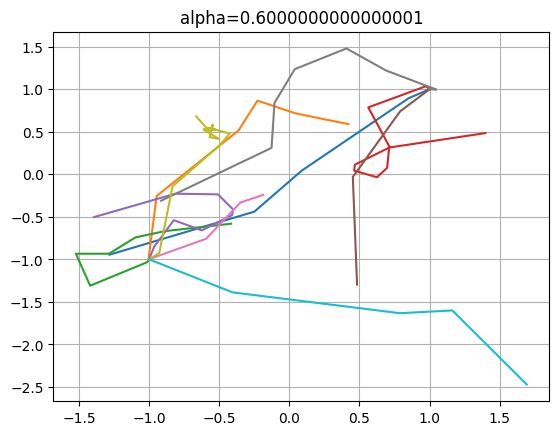

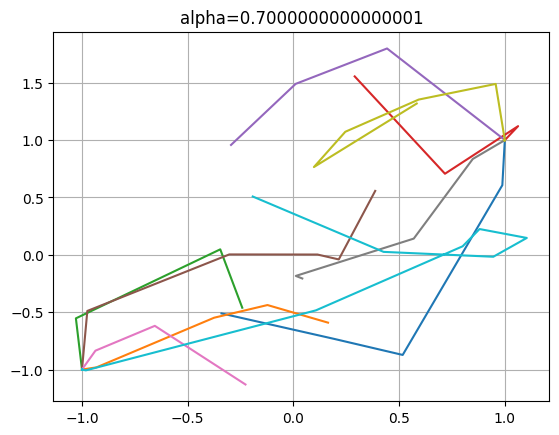

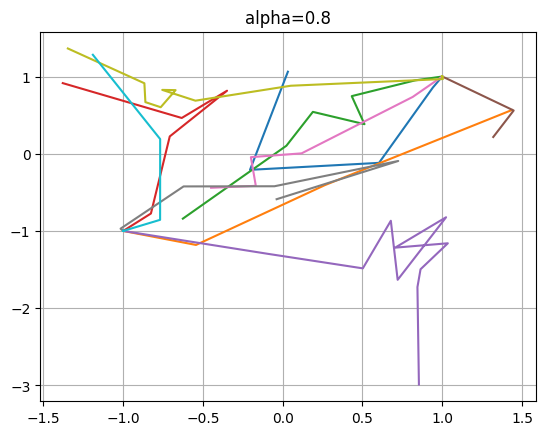

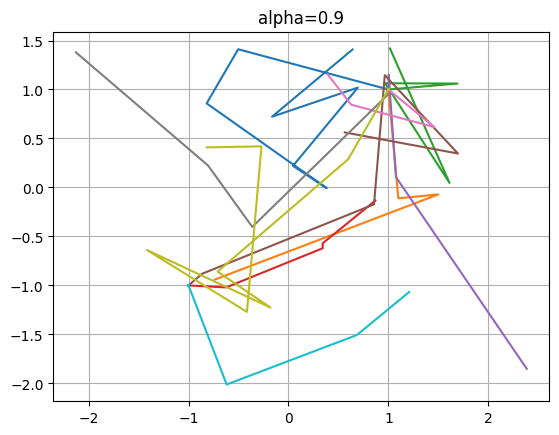

In [506]:
n = 1000
d = 50
alphas = np.arange(0, 10)*0.1
errors = []

for alpha in alphas:
    alpha_error = []
    for j in range(1, 11):  
        # Generate vectors
        x = np.ones(d)
        A = np.random.randn(d, n)
        y = np.square(A.T @ x)
        
        # Run the algorithm
        x_hat = bwgd_subspace_threshold(y, A, r=d, alpha=alpha, niter=30)

        # Plot results
        plt.plot(x_hat[:,0], x_hat[:,1])

    errors.append(alpha_error)
    plt.title(f'alpha={alpha}')
    plt.grid(True)
    plt.show()

In [520]:
U,S,Vt = np.linalg.svd(x_hat[:4])

In [525]:
Vt

array([[ 0.02657518,  0.25821153,  0.08170902, ...,  0.2069921 ,
         0.16187993,  0.14271882],
       [ 0.26288599, -0.05369469,  0.04264338, ..., -0.10173427,
         0.05700462,  0.01786558],
       [ 0.19332981, -0.13562211,  0.26838746, ..., -0.09729052,
        -0.06583649,  0.14270649],
       ...,
       [ 0.15111569, -0.17515916, -0.0024846 , ...,  0.95360454,
        -0.02258469, -0.00752414],
       [-0.00434109, -0.19909547, -0.0656144 , ..., -0.02611249,
         0.96613918, -0.01831419],
       [ 0.03396052, -0.08943006, -0.23943096, ..., -0.01593308,
        -0.03183275,  0.94360407]])

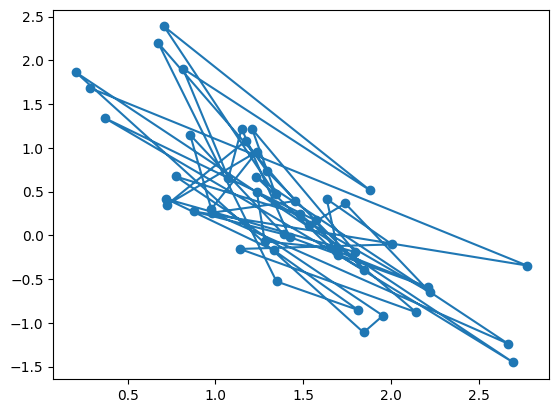

In [527]:
plt.plot(Vt[0]*S[0], Vt[1]*S[1], marker="o")

In [519]:
x_hat[:10]

array([[ 1.20808125, -1.06692056, -0.31812049, -0.58462587,  0.74761511,
        -0.20644838,  0.67094804, -0.23898884,  0.62225965,  0.17383213,
        -1.01989394,  0.93715415, -0.26172439, -0.75279304, -1.03656567,
        -0.70023653,  0.78644042,  0.3270183 ,  1.3652294 , -0.0520947 ,
         2.18757211, -0.10876475,  0.71617621, -0.75335038, -0.02652177,
        -0.56855216, -1.54427169, -1.02801347,  1.86562313,  0.10828864,
        -0.37561726, -1.96505148,  0.05920645, -0.70539085, -2.09197955,
         1.47651216, -1.53965394, -1.57611504,  0.21577239, -0.25670265,
        -1.43365458, -0.69048308, -0.493939  , -0.10174013, -0.60517464,
        -0.63066502, -0.01701329, -1.20080459, -0.17070618, -0.54287988],
       [ 0.68498091, -1.50609284,  0.40882765, -0.18668171, -0.21604281,
         0.02707451, -1.02440295,  0.58400963, -0.43095676, -0.21936555,
        -0.6407147 ,  0.39203528, -0.93223239, -0.60249892, -1.63932604,
         0.0299946 , -0.48751095, -0.66798502,  0.